In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import ray
from ray.experimental.serve.examples.adder import ScalerAdder, VectorizedAdder
from ray.experimental.serve.examples.halt import SleepCounter, SleepOnFirst
from ray.experimental.serve.object_id import unwrap
from ray.experimental.serve.router import DeadlineAwareRouter, start_router
import time

In [24]:
import numpy as np

In [2]:
# We need at least 5 workers so resource won't be oversubscribed
ray.init()

# The following two blobs are equivalent
#
# handle = DeadlineAwareRouter.remote("DefaultTestRouter")
# ray.experimental.register_actor("DefaultTestRouter", handle)
# handle.start.remote()
#
# handle = start_router(DeadlineAwareRouter, "DefaultRouter")
handle = start_router(DeadlineAwareRouter, "DefaultRouter")


2019-03-12 18:05:57,061	WARNING worker.py:1381 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-03-12 18:05:57,063	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-12_18-05-57_55402/logs.
2019-03-12 18:05:57,170	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:30888 to respond...
2019-03-12 18:05:57,298	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:18300 to respond...
2019-03-12 18:05:57,303	INFO services.py:760 -- Starting Redis shard with 3.44 GB max memory.
2019-03-12 18:05:57,323	INFO services.py:1384 -- Starting the Plasma object store with 5.15 GB memory using /tmp.


In [3]:
 handle.register_actor.remote(
        "VAdder", VectorizedAdder,
        init_kwargs={"scaler_increment": 1})

ObjectID(01000000da49c5607d233fd64c0263ffc5530a1b)

In [4]:
a = handle.call.remote("VAdder", 42, time.perf_counter() + 1)

In [5]:
ray.get(unwrap(a))

43

In [9]:
times = []
result = a
for i in range(0, 501, 10):
    for j in range(i):
        result = handle.call.remote("VAdder", 42, time.perf_counter() + 1)
    now = time.perf_counter()
    ray.get(unwrap(result))
    after = time.perf_counter()
    times += [after - now]
    print("# of tasks:", i, "; Latency:", after-now, "ns")

# of tasks: 0 ; Latency: 0.0008473810157738626 ns
# of tasks: 10 ; Latency: 0.030821675958577543 ns
# of tasks: 20 ; Latency: 0.037508583976887167 ns
# of tasks: 30 ; Latency: 0.04954367596656084 ns
# of tasks: 40 ; Latency: 0.06229719496332109 ns
# of tasks: 50 ; Latency: 0.08520741102984175 ns
# of tasks: 60 ; Latency: 0.09304085199255496 ns
# of tasks: 70 ; Latency: 0.10412219702266157 ns
# of tasks: 80 ; Latency: 0.14366800099378452 ns
# of tasks: 90 ; Latency: 0.14964649797184393 ns
# of tasks: 100 ; Latency: 0.1533653439837508 ns
# of tasks: 110 ; Latency: 0.1852983040153049 ns
# of tasks: 120 ; Latency: 0.25398143695201725 ns
# of tasks: 130 ; Latency: 0.4765480720088817 ns
# of tasks: 140 ; Latency: 0.2968332010204904 ns
# of tasks: 150 ; Latency: 0.23383389605442062 ns
# of tasks: 160 ; Latency: 0.2638791939825751 ns
# of tasks: 170 ; Latency: 0.27757205098168924 ns
# of tasks: 180 ; Latency: 0.2800970299867913 ns
# of tasks: 190 ; Latency: 0.29543860198464245 ns
# of tasks: 2

In [12]:
import matplotlib.pyplot as plt

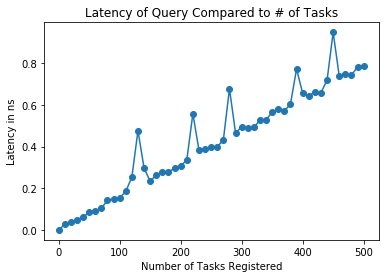

In [22]:
plt.plot([1] + list(range(10,501,10)), times, 'o-')
plt.title("Latency of Query Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Latency in ns");

In [25]:
times = np.array(times)

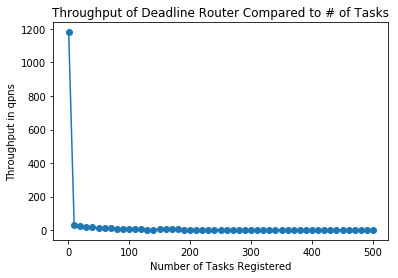

In [28]:
plt.plot([1] + list(range(10,501,10)), 1/times, 'o-')
plt.title("Throughput of Deadline Router Compared to # of Tasks")
plt.xlabel("Number of Tasks Registered")
plt.ylabel("Throughput in qpns");